In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import seaborn as sns

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf


In [2]:
dftrain = pd.read_csv('laptop_price_train.csv', encoding = 'latin-1')
dfeval = pd.read_csv('laptop_price_eval.csv', encoding = 'latin-1')
dftrain.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [3]:
ytrain = dftrain.pop('Price_euros')
yeval = dfeval.pop('Price_euros')

In [4]:
dftrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
laptop_ID,1042.0,527.744722,304.354554,1.0,265.25,527.5,789.75,1055.0
Inches,1042.0,15.024856,1.411870,10.1,14.00,15.6,15.60,18.4


<AxesSubplot:>

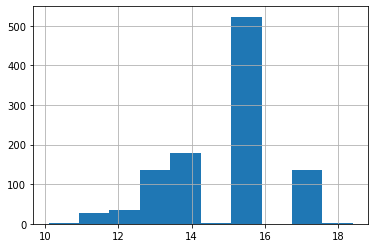

In [5]:
dftrain.Inches.hist()

Text(0.5, 0, 'Company')

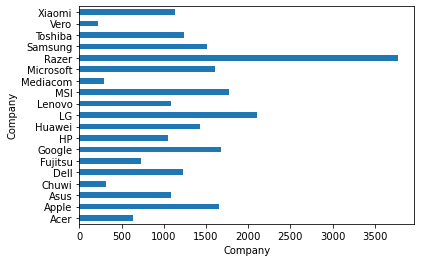

In [6]:
pd.concat([dftrain, ytrain], axis = 1).groupby('Company').Price_euros.mean().plot(kind = 'barh').set_xlabel('Company')

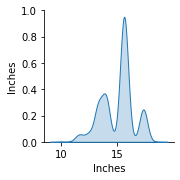

In [7]:
dftrain.head()
sns.pairplot(dftrain[['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight']], diag_kind='kde')

Trying to build a boxplot showing prices range of different brands in one graph. 

In [ ]:
pd.concat([dftrain['Company'], ytrain], axis = 1).groupby('Company').plot(kind = 'box').set_xlabel()

### Converting categorical data into numerical data:

In [8]:
print(dftrain.dtypes)
dftrain.shape
dftrain.dtypes

laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
dtype: object


laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
dtype: object

In [9]:
dftrain_new = pd.get_dummies(dftrain)

In [16]:
CATEGORICAL_COLUMNS = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight'] 
NUMERIC_COLUMNS = ['Inches']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

## Building and running the Linear Regression Model:

In [17]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain_new, ytrain)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, yeval, num_epochs=1, shuffle=False)


In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Narayan\\AppData\\Local\\Temp\\tmp71bqwpdl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [19]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

INFO:tensorflow:Calling model_fn.


C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


ValueError: in user code:

    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1671 call  *
        return self.layer(features)
    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1499 call  *
        weighted_sum = fc_v2._create_weighted_sum(  # pylint: disable=protected-access
    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2133 _create_weighted_sum  **
        return _create_categorical_column_weighted_sum(
    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2225 _create_categorical_column_weighted_sum
        sparse_tensors = column.get_sparse_tensors(transformation_cache,
    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:3582 get_sparse_tensors
        transformation_cache.get(self, state_manager), None)
    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2355 get
        transformed = column.transform_feature(self, state_manager)
    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:3559 transform_feature
        transformation_cache.get(self.key, state_manager))
    C:\Users\Narayan\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2339 get
        raise ValueError('Feature {} is not in features dictionary.'.format(key))

    ValueError: Feature Company is not in features dictionary.
